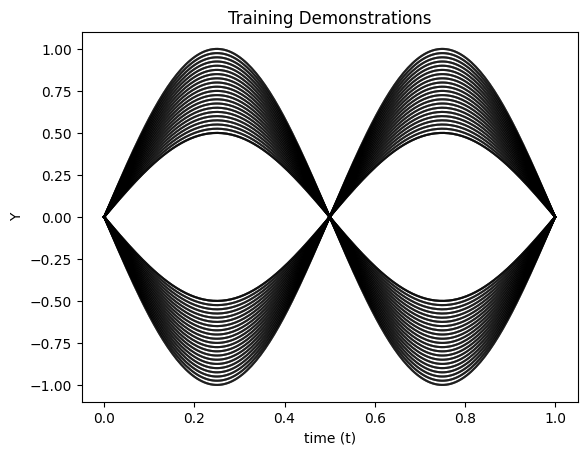

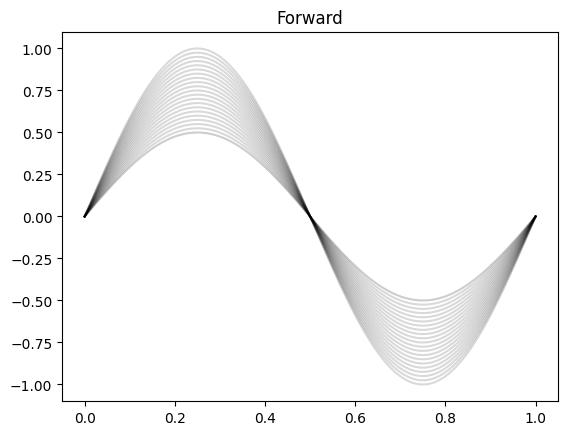

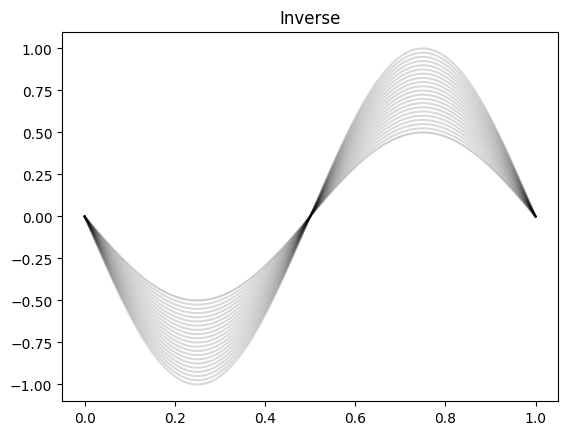

In [487]:
from cProfile import label
from re import X
from turtle import color
from sympy import li
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as D
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import math
import importlib

import dual_enc_dec_cnmp as dual_enc_dec_cnmp
import utils
importlib.reload(dual_enc_dec_cnmp)
importlib.reload(utils)

#params = np.array([[2,0],[2,0],[2,0],[2,0],[2,0],[-0.6,0.1],[-0.55, 0.16],[-0.5,0.23],[-0.45, 0.33],[-0.4,0.43]])
params = np.array([[20],[19.9],[19.7]])

num_demo = 64
X1, X2, Y1, Y2, validation_Y1, validation_Y2 = utils.generate_demonstrations(num_demo, time_len=200, params = params, plot_title='Training')

In [491]:
demo_data = [X1, X2, Y1, Y2]
d_x = 1
d_y1 = 1
d_y2 = 1
OBS_MAX = 1
d_N = num_demo
time_len = 200

validation_indices_1 = [i+1 for i in range(0, num_demo-1, 7)]
validation_indices_2 = [i+2 for i in range(0, num_demo-2, 7)]
validation_indices = validation_indices_1 + validation_indices_2

## convert to tensor, use sourceTensor.clone().detach() to get a new tensor
X1 = torch.tensor(X1, dtype=torch.float32)
X2 = torch.tensor(X2, dtype=torch.float32)
Y1 = torch.tensor(Y1, dtype=torch.float32)
Y2 = torch.tensor(Y2, dtype=torch.float32)
validation_Y1 = torch.tensor(validation_Y1, dtype=torch.float32)
validation_Y2 = torch.tensor(validation_Y2, dtype=torch.float32)



/var/folders/63/kw9gvntx3hzftcn6fp7wkf0c0000gn/T/ipykernel_17200/1667249149.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X1 = torch.tensor(X1, dtype=torch.float32)
/var/folders/63/kw9gvntx3hzftcn6fp7wkf0c0000gn/T/ipykernel_17200/1667249149.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X2 = torch.tensor(X2, dtype=torch.float32)
/var/folders/63/kw9gvntx3hzftcn6fp7wkf0c0000gn/T/ipykernel_17200/1667249149.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y1 = torch.tensor(Y1, dtype=torch.float32)
/var/folders/63/kw9gvntx3hzf

In [514]:
from ftplib import error_perm


importlib.reload(dual_enc_dec_cnmp)
importlib.reload(utils)


errors = []
losses = []
errors_with_latent = []

def train():

    model = dual_enc_dec_cnmp.DualEncoderDecoder(d_x, d_y1, d_y2)

    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    def lr_lambda(epoch):
        if epoch < 7000:
            return 1e-4 / optimizer.defaults['lr']  # Scale factor for 1e-3
        elif 7000 <= epoch < 100000:
            return 1e-4 / optimizer.defaults['lr']  # Scale factor for 1e-4
        elif 100000 <= epoch < 300000:
            return 1e-5 / optimizer.defaults['lr']  # Scale factor for 1e-5
        else:
            return 1e-6 / optimizer.defaults['lr']
    
    
    scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

    error = 0

    for i in range(EPOCHS):

        obs, mask, x_tar, y_tar_f, y_tar_i = dual_enc_dec_cnmp.get_training_sample(validation_indices, X1, Y1, X2, Y2, OBS_MAX, d_N, d_x, d_y1, d_y2, time_len)
        optimizer.zero_grad()
        output, L_F, L_I = model(obs, mask, x_tar)

        loss = dual_enc_dec_cnmp.loss(output, y_tar_f, y_tar_i, d_y1, d_y2, L_F.squeeze(1), L_I.squeeze(1))
        loss.backward()

        optimizer.step()
        scheduler.step()

        # VALIDATION
        if i % 100 == 0:
            losses.append(loss.item())
            if i % 1000 == 0:
                
                # print(f'Epoch: {i}, Loss: {loss.item()}')
                error = 0
                plot_id = np.random.randint(0, len(validation_indices))
                for validation_idx in validation_indices:
                    time = np.linspace(0, 1, time_len)
                    # permute time
                    idx = np.random.permutation(time_len)
                    idx = idx[:OBS_MAX]
                    time = [time[i] for i in idx]
                    condition_points = [[t, Y1[validation_idx, i:i+1]] for t,i in zip(time, idx)]
                    means, stds = dual_enc_dec_cnmp.predict_inverse(model, validation_idx, time_len, condition_points, d_x, d_y1, d_y2, demo_data)
                    if i % 10000 == 0 and validation_idx == validation_indices[plot_id]:
                        error += utils.validate_model(means, stds, validation_idx, demo_data, time_len, condition_points, i, plot=True)
                    else:
                        error += utils.validate_model(means, stds, validation_idx, demo_data, time_len, condition_points, i, plot=False)

                    latent_loss = loss - dual_enc_dec_cnmp.log_prob_loss(output, y_tar_f, y_tar_i, d_y1, d_y2)
                error_with_latent = error + latent_loss.item()
                errors_with_latent.append(error_with_latent)
                errors.append(error)
                if error == min(errors):
                    print('Saving model ', i)
                    print('loss: ', loss.item())  
                    print('latent loss: ', latent_loss.item())  
                    torch.save(model.state_dict(), 'inverse_best_model.pth')

                errors_with_latent.append(error_with_latent)

torch.Size([64, 200, 1])


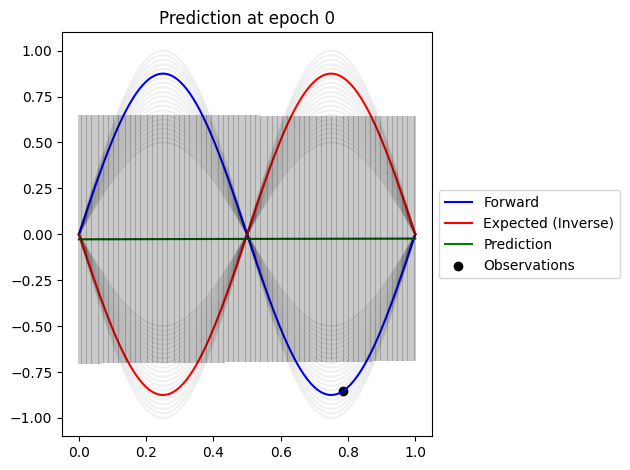

Saving model  0
loss:  19.954177856445312
latent loss:  18.203838348388672
Saving model  1000
loss:  0.08694460242986679
latent loss:  0.008455790579319
Saving model  4000
loss:  -0.5008205771446228
latent loss:  0.06790274381637573
Saving model  5000
loss:  -0.21522866189479828
latent loss:  0.05133675038814545
Saving model  6000
loss:  1.6975035667419434
latent loss:  0.038941144943237305
Saving model  7000
loss:  -0.8186116814613342
latent loss:  0.03178274631500244
Saving model  8000
loss:  -0.6572045087814331
latent loss:  0.09279757738113403
Saving model  9000
loss:  -1.6818290948867798
latent loss:  0.06575560569763184
torch.Size([64, 200, 1])


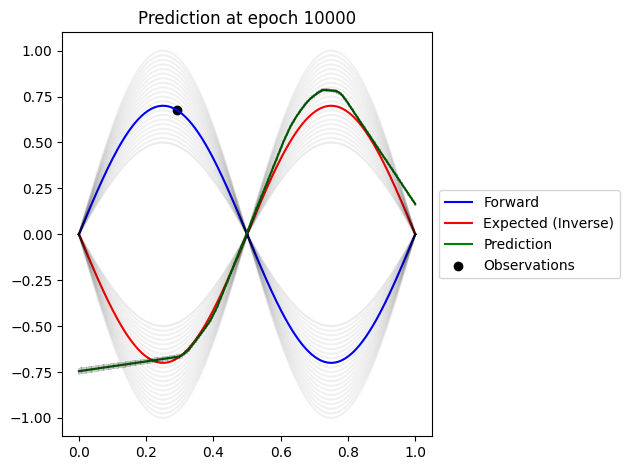

Saving model  10000
loss:  -1.3321099281311035
latent loss:  0.0914987325668335
Saving model  12000
loss:  -1.1238975524902344
latent loss:  0.17063021659851074
Saving model  13000
loss:  -1.9207826852798462
latent loss:  0.29620182514190674
Saving model  15000
loss:  -1.4685308933258057
latent loss:  0.22482633590698242
Saving model  17000
loss:  -2.7588565349578857
latent loss:  0.10088729858398438
Saving model  18000
loss:  -1.4781403541564941
latent loss:  0.3478281497955322
torch.Size([64, 200, 1])


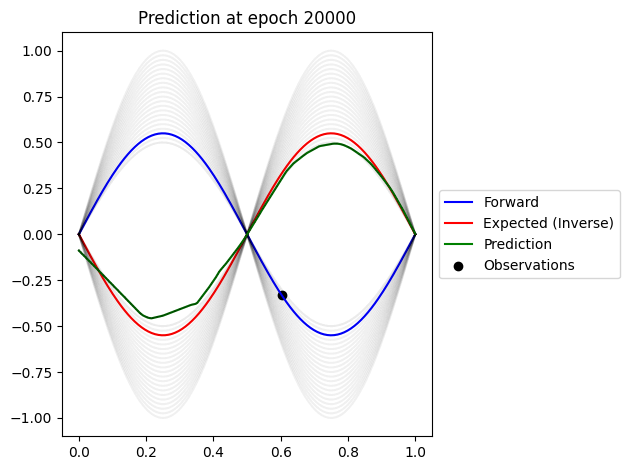

Saving model  20000
loss:  -2.9022393226623535
latent loss:  0.0981900691986084
Saving model  24000
loss:  -1.7792911529541016
latent loss:  0.18939507007598877
torch.Size([64, 200, 1])


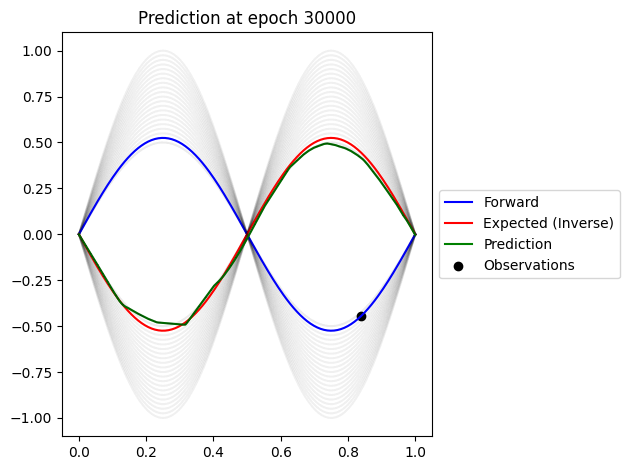

Saving model  31000
loss:  -5.444371700286865
latent loss:  -0.13494586944580078
Saving model  39000
loss:  -4.712658882141113
latent loss:  0.1965031623840332
torch.Size([64, 200, 1])


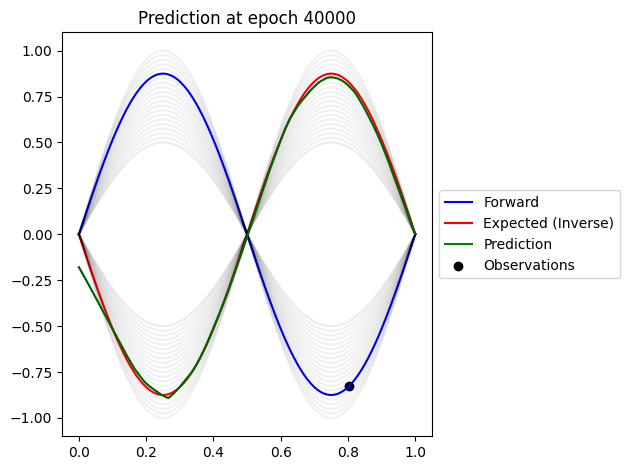

Saving model  46000
loss:  -4.7807159423828125
latent loss:  0.30169010162353516
Saving model  47000
loss:  -5.007724285125732
latent loss:  0.021183490753173828
torch.Size([64, 200, 1])


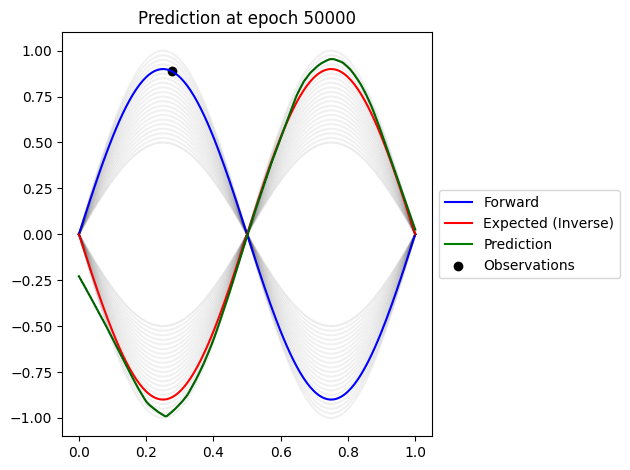

Saving model  58000
loss:  -3.62551212310791
latent loss:  0.33169126510620117
torch.Size([64, 200, 1])


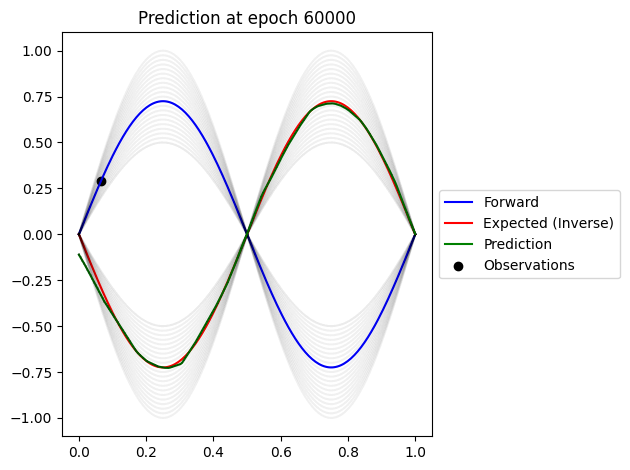

Saving model  64000
loss:  -4.789734840393066
latent loss:  0.20897817611694336
torch.Size([64, 200, 1])


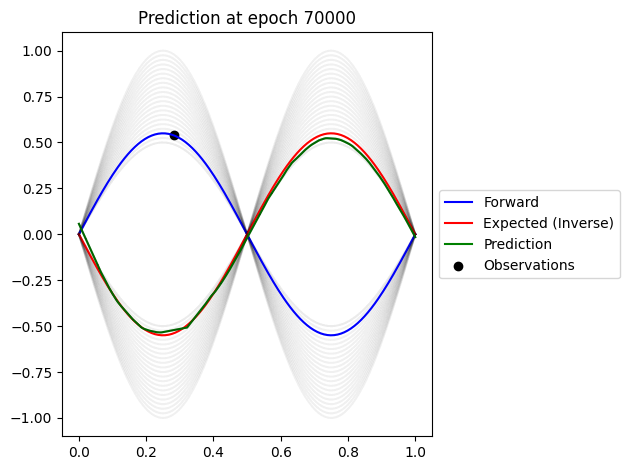

torch.Size([64, 200, 1])


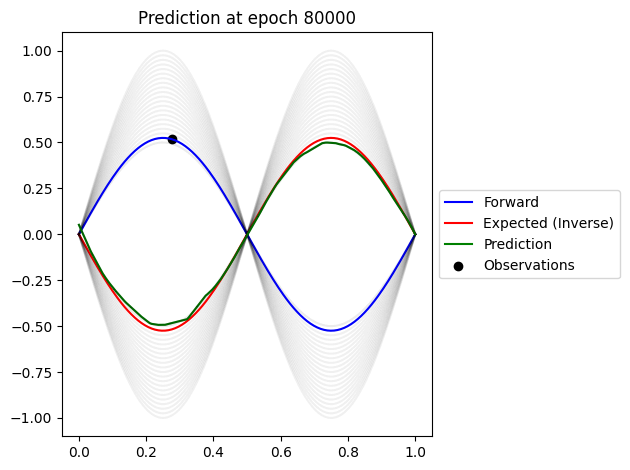

Saving model  81000
loss:  -5.3994855880737305
latent loss:  0.15478849411010742
torch.Size([64, 200, 1])


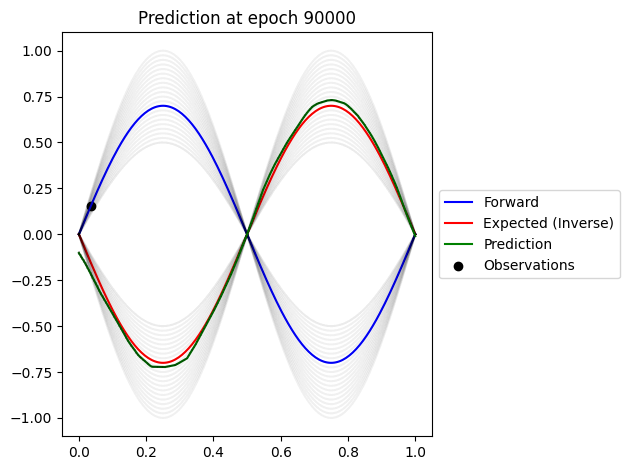

Saving model  95000
loss:  -4.010633945465088
latent loss:  -0.09367728233337402
torch.Size([64, 200, 1])


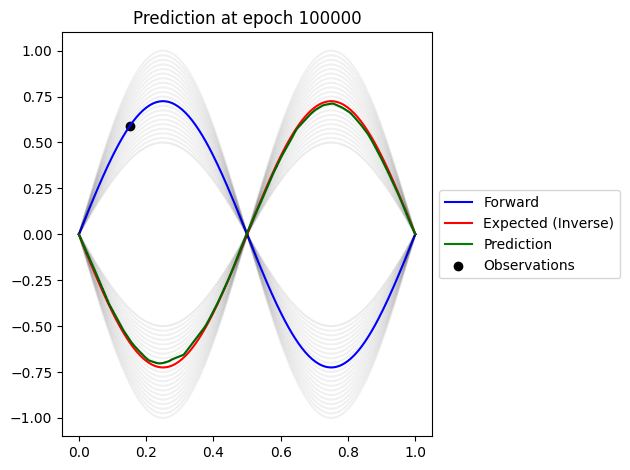

Saving model  101000
loss:  -5.87581729888916
latent loss:  0.34288978576660156
torch.Size([64, 200, 1])


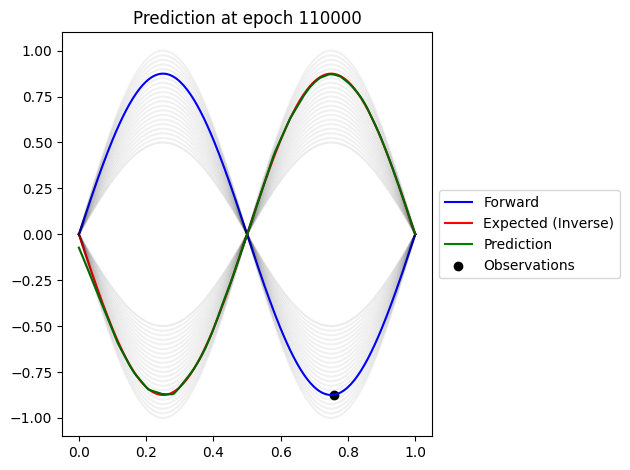

Saving model  111000
loss:  -7.474400043487549
latent loss:  -0.03501176834106445
torch.Size([64, 200, 1])


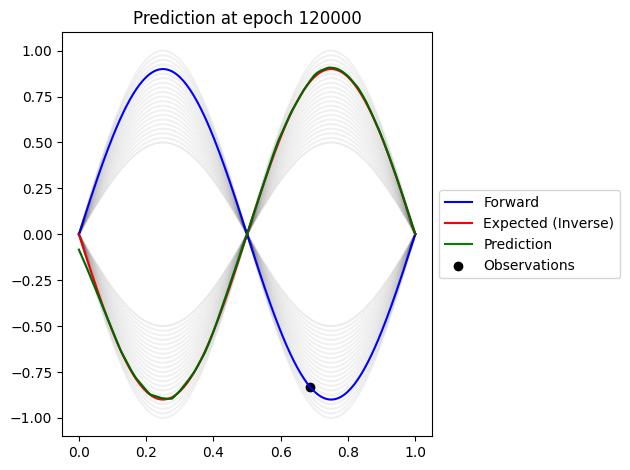

torch.Size([64, 200, 1])


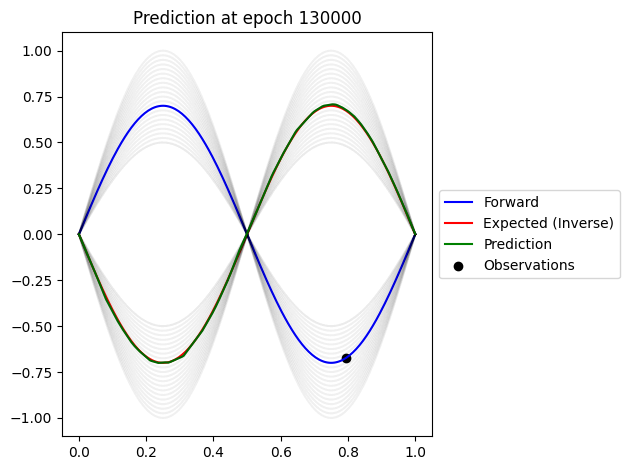

torch.Size([64, 200, 1])


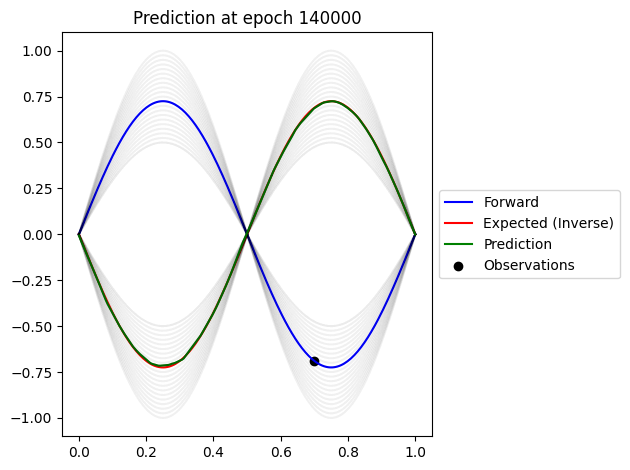

KeyboardInterrupt: 

In [515]:
importlib.reload(dual_enc_dec_cnmp)
importlib.reload(utils)

EPOCHS = 500000
learning_rate = 1e-4

train()

In [516]:
best_model = dual_enc_dec_cnmp.DualEncoderDecoder(d_x, d_y1, d_y2)
best_model.load_state_dict(torch.load('inverse_best_model.pth'))

/var/folders/63/kw9gvntx3hzftcn6fp7wkf0c0000gn/T/ipykernel_17200/1488616078.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load('invers

<All keys matched successfully>

In [ ]:
importlib.reload(dual_enc_dec_cnmp)
importlib.reload(utils)

t = 0.25
min_y_f = torch.min(Y1[:, int(t * time_len)])
max_y_f = torch.max(Y1[:, int(t * time_len)])
interval_y_f = np.linspace(min_y_f-0.1, max_y_f+0.1, 20)

min_y_i = torch.min(Y2[:, int(t * time_len)])
max_y_i = torch.max(Y2[:, int(t * time_len)])
interval_y_i = torch.linspace(min_y_i-0.1, max_y_i+0.1, 20)

# plot latent losses
plt.plot(errors_with_latent)
plt.show()

i = 0
for idx in interval_y_f:
    condition_points = [[t, torch.tensor([idx])]]
    means, stds = dual_enc_dec_cnmp.predict_inverse(best_model, 1, time_len, condition_points, d_x, d_y1, d_y2, demo_data)
    if i == 0:
        utils.plot_results(means, stds, Y1, Y2, idx, condition_points, errors, losses, time_len, d_N, plot_errors = True)
        i += 1
    utils.plot_results(means, stds, Y1, Y2, idx, condition_points, errors, losses, time_len, d_N, plot_errors = False)


(60, 1, 128)
(60, 128)
(60, 2)


/var/folders/63/kw9gvntx3hzftcn6fp7wkf0c0000gn/T/ipykernel_17200/2039838879.py:101: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


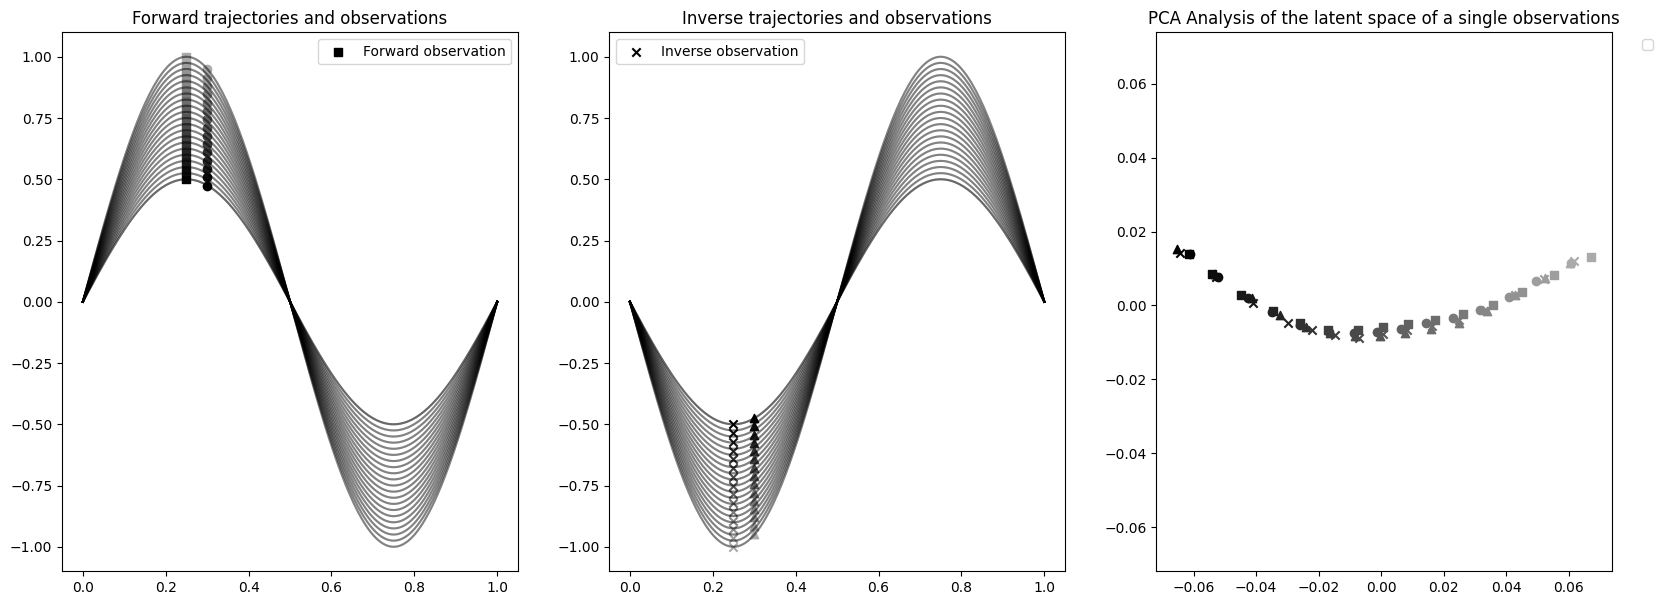

In [ ]:

importlib.reload(dual_enc_dec_cnmp)
importlib.reload(utils)
from mpl_toolkits.mplot3d import Axes3D
from sympy import intervals


time = [0.25, 0.75]

## do the same for t = 0.25 and t = 0.75, obtain the pca result for all the points

intervals_y_f = []
intervals_y_i = []

all_observations_f = []  
all_observations_i = []


NUM_STEP = 15

for t in time:
    min_y_f = torch.min(Y1[:, int(t * time_len)])
    max_y_f = torch.max(Y1[:, int(t * time_len)])
    interval_y_f = torch.linspace(min_y_f, max_y_f, NUM_STEP)
    if t > 0.5:
        interval_y_f = torch.flip(interval_y_f, dims=[0])
    intervals_y_f.append(interval_y_f)

    min_y_i = torch.min(Y2[:, int(t * time_len)])
    max_y_i = torch.max(Y2[:, int(t * time_len)])
    interval_y_i = torch.linspace(min_y_i, max_y_i, NUM_STEP)
    if t < 0.5:
        interval_y_i = torch.flip(interval_y_i, dims=[0])
    intervals_y_i.append(interval_y_i)

    for idx in interval_y_f:
        condition_points = [[t, idx]]
        all_observations_f.append(condition_points)
    for idx in interval_y_i:
        condition_points = [[t, idx]]
        all_observations_i.append(condition_points)

all_observations_f = torch.tensor(all_observations_f)
all_observations_i = torch.tensor(all_observations_i)


pca_result = dual_enc_dec_cnmp.plot_latent_space(best_model, all_observations_f, all_observations_i) # [ft0, ft1, ... , it0, it1, ...]

## open 2 subplots
fig, axs = plt.subplots(1, 3, figsize=(20, 7))


for forward_traj in Y1:
    axs[0].plot(torch.linspace(0, 1, time_len), forward_traj, c='black', alpha=0.2)
for inverse_traj in Y2:
    axs[1].plot(torch.linspace(0, 1, time_len), inverse_traj, c='black', alpha=0.2)
axs[0].set_title("Forward trajectories and observations")
axs[1].set_title("Inverse trajectories and observations")

for i in range(len(intervals_y_f)):
    for j in range(len(intervals_y_f[i])):
        if i == 0 and j == 0:
            axs[0].scatter(time[i], intervals_y_f[i][j], marker="s", c=f"{(j)/(1.4*len(interval_y_f))}", label='Forward observation')
        else:
            if i == 0:
                axs[0].scatter(time[i], intervals_y_f[i][j], marker="s", c=f"{(j)/(1.4*len(interval_y_f))}")
            else:
                axs[0].scatter(time[i], intervals_y_f[i][j], c=f"{(j)/(1.4*len(interval_y_f))}")

for i in range(len(intervals_y_i)):
    for j in range(len(intervals_y_i[i])):
        if i == 0 and j == 0:
            axs[1].scatter(time[i], intervals_y_i[i][j], marker="x", c=f"{(j)/(1.4*len(interval_y_i))}", label='Inverse observation')
        else:
            if i == 0:
                axs[1].scatter(time[i], intervals_y_i[i][j], marker="x", c=f"{(j)/(1.4*len(interval_y_i))}")
            else:
                axs[1].scatter(time[i], intervals_y_i[i][j], marker="^", c=f"{(j)/(1.4*len(interval_y_i))}")

axs[0].legend()
axs[1].legend()

print(pca_result.shape)
pca_result = np.array(pca_result)
pca_result_f1, pca_result_f2, pca_result_i1, pca_result_i2 = pca_result[:15], pca_result[15:30], pca_result[30:45], pca_result[45:]

pca_result = np.array([pca_result_f1, pca_result_f2, pca_result_i1, pca_result_i2])

dict_markers = {0:'s', 1:'o', 2:'x', 3:'^'}

for i in range(4):
    for j in range(15):
        axs[2].scatter(pca_result[i, j, 0], pca_result[i, j, 1], marker=dict_markers[i], c=f"{(j)/(1.4*15)}")
    axs[2].set_title("PCA Analysis of the latent space of a single observations")
    
## make x and y axis equal

axs[2].set_ylim(axs[2].get_xlim())
    

plt.title("PCA Analysis of the latent space of a single observations")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

